## 1. Selekcja zmiennych

Do przeprowadzenia wstępnej selekcji zmiennych wykorzystamy trzy miary: korelację spearmana, mutual information oraz random forest feature importance. Policzenie korelacji pozwoli dostrzec, czy między niektórymi zmiennymi objaśniającymi nie ma zbyt silnych korelacji, gdyż wówczas takich zmiennych należy sie pozbyć. Natomiast mutual information i feature importance da nam informacje, które zmienne są najcenniejsze dla prognozowania naszej zmiennej zależnej i czy może nie należy wzmocnić ich znaczenia

In [1]:
#Wczytanie potrzebnych bibliotek
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7, 5)
import seaborn as sns
sns.set_theme()
import os
import json
path=os.getcwd()
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier


In [2]:
#Wczytanie danych
train = pd.read_csv(path+'\\data\\data_prepare.csv')
with open(path+"/data/cat_dig_features.txt", "r") as file:
    cat_dig_features=json.loads(file.read())
with open(path+"/data/cat_str_features.txt", "r") as file:
    cat_str_features=json.loads(file.read())
with open(path+"/data/num_features.txt", "r") as file:
    num_features=json.loads(file.read())
train[cat_dig_features]=train[cat_dig_features].astype('object')
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Gender                                103904 non-null  object 
 1   Customer_Type                         103904 non-null  object 
 2   Age                                   103904 non-null  int64  
 3   Type_of_Travel                        103904 non-null  object 
 4   Class                                 103904 non-null  object 
 5   Flight_Distance                       103904 non-null  int64  
 6   Inflight_wifi_service                 103904 non-null  object 
 7   Departure_Or_Arrival_time_convenient  103904 non-null  object 
 8   Ease_of_Online_booking                103904 non-null  object 
 9   Gate_location                         103904 non-null  object 
 10  Food_and_drink                        103904 non-null  object 
 11  

Przygotujmy zmienne do selekcji i inżynierii. Na zmiennych kategorycznych zastosujmy label encoding.

In [3]:
# Robimy przekształcenie zmiennych za pomocą funkcji Label Encoder, która nadaje kolejnym poziomom wartości numeryczne. 
# Dla stringów robi to alfabetycznie
data_for_selection=train.copy()
mapy={}
for feature in cat_str_features+cat_dig_features:
    le = preprocessing.LabelEncoder()
    data_for_selection[feature] = le.fit_transform(train[feature])
    mapy[feature] = le
    print(feature, dict(zip(mapy[feature].classes_,mapy[feature].transform(mapy[feature].classes_))))
le = preprocessing.LabelEncoder()
data_for_selection['satisfaction'] = le.fit_transform(train['satisfaction'])
mapy['satisfaction']=le
print('satsifaction',dict(zip(mapy['satisfaction'].classes_,mapy['satisfaction'].transform(mapy['satisfaction'].classes_))))

Gender {'Female': 0, 'Male': 1}
Customer_Type {'Loyal Customer': 0, 'disloyal Customer': 1}
Type_of_Travel {'Business travel': 0, 'Personal Travel': 1}
Class {'Business': 0, 'Eco': 1, 'Eco Plus': 2}
Inflight_wifi_service {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
Departure_Or_Arrival_time_convenient {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
Ease_of_Online_booking {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
Gate_location {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
Food_and_drink {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
Online_boarding {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
Seat_comfort {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
Inflight_entertainment {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
Onboard_service {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
Leg_room_service {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
Baggage_handling {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
Checkin_service {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
Inflight_service {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
Cleanliness {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
satsifaction {'neutral or dissa

### 1.1 Macierz korelacji

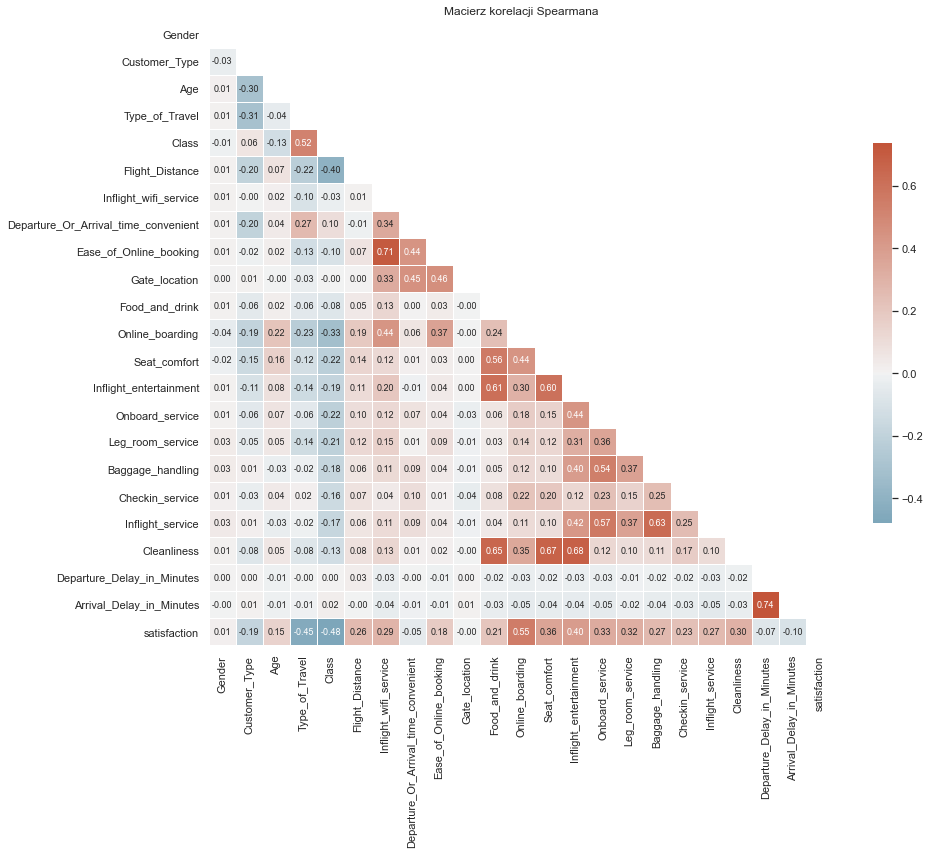

In [4]:
#Obliczenie korelacji za pomocą metody spearmana
corr_matrix=data_for_selection.corr('spearman')
#Stworzenie heatmapy z korelacjami 
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(14, 14))
cmap=sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True,annot_kws={"size":9},fmt='.2f')
plt.title('Macierz korelacji Spearmana')
plt.savefig(path+'\\img\\corr_matrix.png')
plt.show()

Silne korelacje(dodatnie) pomiędzy zmiennymi (powyżej 0.7) zachowują dwie pary zmiennych: Departure Delay in Minutes z Arrival Delay in Minutes oraz Ease of Online booking z inflight wifi service. W pierwszym przypadku jest to oczywista korelacja, gdyż im więcej minut opóźnienia ma samolot przy odlocie tym samym jest duże prawdopobieństwo, że czas przylotu też będzie przekroczony. Druga skorelowana para jest już trudniejsza do wyjaśnienia, gdyż nie jestem w stanie bez dodatkowej wiedzy wytłumaczyć czemu łatwość w rezerwowaniu lotu online przekłada się na pokładową usługę wifi. 

Przyglądając się korelacjom między zmienną zależną a objaśniającymi nie widać bardzo silnych korelacji, ani dodatnich ani ujemnych. Największa korelacja dodatnia z satisfaction należy do zmiennej online boarding(0.55) a ujemna do Class (-0.48).
W pierwszym przypadku lepsza ocena korzystania z usług online dot. lotu wpływa pozytywnie na ostateczną decyzję o zadowoleniu z usług linii lotniczych. Co do drugiej zmiennej została ona zakodowana w taki sposób, że klasa Business jest oznaczona jako 0, Eco jako 1 a Eco Plus jako 2. Dlatego korelacja jest ujemna, gdyż zgodnie z przewidywaniami pasażerowie z klasy biznesowej częściej są usatysfakcjonowani (oznaczone jako 1) z linii lotniczych. Aby dokładniej zbadać zależności (szczególnie te niemonotoniczne) sprawdzono zmienne za pomocą statystyki mutual information

### 1.2 Mutual information

In [5]:
#Obliczenia mutual information dla kategorycznych oraz numerycznych zmiennych
mut_info=[]
for feature in cat_str_features+cat_dig_features:
    mut_info.append(feature_selection.mutual_info_classif(data_for_selection[feature].values.reshape(-1,1),data_for_selection['satisfaction'].values)[0])
for feature in num_features:
    mut_info.append(feature_selection.mutual_info_classif(data_for_selection[feature].values.reshape(-1,1),data_for_selection['satisfaction'].values)[0])
    
mut_info_list = list(zip(mut_info, cat_str_features+cat_dig_features+num_features))
mut_info_list.sort(reverse=True)
display('Posortowana lista zmiennych z mutual information',mut_info_list)

'Posortowana lista zmiennych z mutual information'

[(0.21409165690220266, 'Online_boarding'),
 (0.16550450698628905, 'Inflight_wifi_service'),
 (0.1359406079285399, 'Class'),
 (0.11531146043432083, 'Type_of_Travel'),
 (0.09640031272664151, 'Inflight_entertainment'),
 (0.08185499348613301, 'Seat_comfort'),
 (0.06329178381833978, 'Flight_Distance'),
 (0.06178954893357713, 'Leg_room_service'),
 (0.06080125206549658, 'Onboard_service'),
 (0.05514171474167484, 'Cleanliness'),
 (0.054513935112310286, 'Ease_of_Online_booking'),
 (0.04764671935664788, 'Age'),
 (0.04476411089003762, 'Baggage_handling'),
 (0.044526550753645644, 'Inflight_service'),
 (0.03557339876571586, 'Checkin_service'),
 (0.030642329594057438, 'Food_and_drink'),
 (0.019952874028978496, 'Customer_Type'),
 (0.014137468103164519, 'Gate_location'),
 (0.004858356344883408, 'Gender'),
 (0.00470836423903731, 'Arrival_Delay_in_Minutes'),
 (0.003977262475208132, 'Departure_Delay_in_Minutes'),
 (0.0026728857060003275, 'Departure_Or_Arrival_time_convenient')]

Ciekawym pomysłem jest również przyjrzenie się feature importance uzyskanego z prostego modelu RandomForest

In [6]:
X=data_for_selection.loc[:, data_for_selection.columns != 'satisfaction']
y=data_for_selection['satisfaction']
rf = RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(X,y)
feat_imp_list=dict(zip(X.columns.tolist(),rf.feature_importances_))

In [7]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + '-FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    #Save figure to png file
    plt.savefig(path+'\\img\\RandomForest-FeatureImportance.png')
    plt.show()

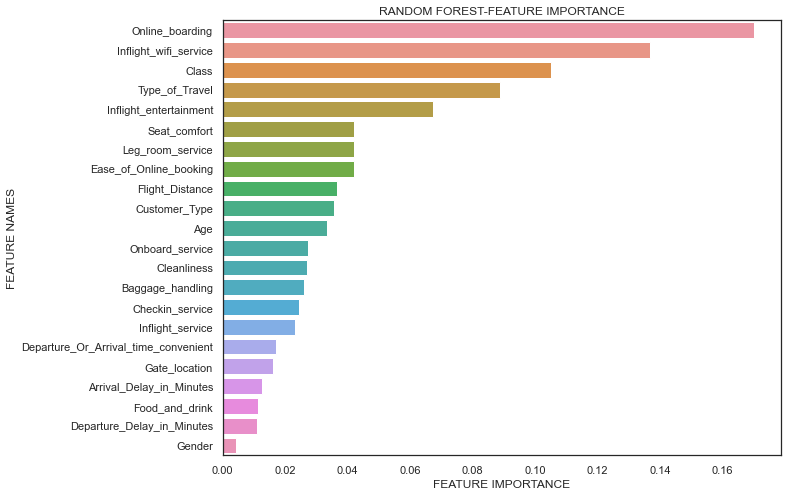

In [8]:
plot_feature_importance(list(feat_imp_list.values()),list(feat_imp_list.keys()),'RANDOM FOREST')

Zarówno mutual information jak i feature importance dają identyczne wyniki. Najbardziej istotne zmienne to Online boarding, inflight wifi service, Class, Type of Travel oraz Inflight entertainment. Natomiast najgorzej według tych 2 statystyk różnicują Gate location, Arrival Delay in Minutes, Food and drink, Departure Delay in Minutes oraz Gender. Już wstępna analiza danych dawała wskazówki, że płeć może słabo różnicować satisfaction, gdyż nie były widoczne żadne różnice na wykresie. Warto zastanowić się, czy nie usunąć tej zmiennej w celu redukcji wymiarowości.


## 2. Inżynieria zmiennych

W procesie inżynierii zmiennych istotne jest ewaluowanie przeprowadzonych zmian w trakcie za pomocą prostego modelu.
W tym celu zostanie wykorzystany prosty wrapper dla randomForest aby testować modyfikacje zbioru danych.

In [9]:

# Przygotujmy wrapper
def CVTestRFClass(df,nFolds = 5, randomState=42, debug=False, features=[], *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # listy do przechowywania wyników:
    testResults = []
    trainResults = []

    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = RandomForestClassifier(*args, **kwargs, random_state=randomState, n_jobs=-1)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Policzenie dopasowania za pomocą metryki ROC-AUC
        trainScore = roc_auc_score((df[target].iloc[train]==1).astype(int), predsTrain)
        testScore = roc_auc_score((df[target].iloc[test]==1).astype(int), preds)
        
        # Zapisanie wyników do listy 
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults


Warto stworzyć pierwszy model dla wszystkich zmiennych aby można byłoby porówynywać wyniki

In [10]:
#lista zmiennych objasniajacych
engine_data=data_for_selection.copy()
features=engine_data.columns.tolist()
features.remove('satisfaction')
target='satisfaction'
engine_data.head()

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure_Or_Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Inflight_entertainment,Onboard_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,1,0,13,1,2,460,3,4,3,1,...,5,4,3,3,4,5,5,25,18.0,0
1,1,1,25,0,0,235,3,2,3,3,...,1,1,5,2,1,4,1,1,6.0,0
2,0,0,26,0,0,1142,2,2,2,2,...,5,4,3,3,4,4,5,0,0.0,1
3,0,0,25,0,0,562,2,5,5,5,...,2,2,5,2,1,4,2,11,9.0,0
4,1,0,61,0,0,214,3,3,3,3,...,3,3,4,3,3,3,3,0,0.0,1


In [11]:
trainResults, testResults = CVTestRFClass(df=engine_data,features=features)
print(np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

1.0 0.9937251524798503 0.006274847520149729


Wynik 0.9937 jest wyjściowy i poprzez inżynierię zmiennych będziemy chcieli go zwiększyć. Najpierw sprawdźmy czy wyniki się poprawi jeżeli poradzimy sobie z małolicznymi grupami.

### 2.1 Poziomy o małych ilościach obserwacji

Pierwszą istotną kwestią jest zarządzenie zmiennymi kategorycznymi, które posiadają małoliczne poziomy. Przypomnienie, które są to zmienne

In [12]:
for col in cat_dig_features:
    if(any(x<0.01*len(engine_data)for x in engine_data[col].value_counts().values.tolist())):
        print(engine_data[col].value_counts())

3    28577
4    24426
2    19459
1    17562
5    13879
0        1
Name: Gate_location, dtype: int64
4    24359
5    22313
3    22300
2    21988
1    12837
0      107
Name: Food_and_drink, dtype: int64
4    31765
5    26470
3    18696
2    14897
1    12075
0        1
Name: Seat_comfort, dtype: int64
4    29423
5    25213
3    19139
2    17637
1    12478
0       14
Name: Inflight_entertainment, dtype: int64
4    30867
5    23648
3    22833
2    14681
1    11872
0        3
Name: Onboard_service, dtype: int64
4    28789
5    24667
3    20098
2    19525
1    10353
0      472
Name: Leg_room_service, dtype: int64
4    29055
3    28446
5    20619
2    12893
1    12890
0        1
Name: Checkin_service, dtype: int64
4    37945
5    27116
3    20299
2    11457
1     7084
0        3
Name: Inflight_service, dtype: int64
4    27179
3    24574
5    22689
2    16132
1    13318
0       12
Name: Cleanliness, dtype: int64


In [13]:
#Zastępowanie wartosci 0 najliczniejszym poziomem
engine_data2=engine_data.copy()
for col in cat_dig_features:
    if(any(x<0.01*len(engine_data2)for x in engine_data2[col].value_counts().values.tolist())):
        engine_data2[col].replace(0,engine_data2[col].mode()[0],inplace=True)

In [14]:
trainResults, testResults = CVTestRFClass(df=engine_data2,features=features)
print(np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

1.0 0.9936460809205805 0.006353919079419512


In [15]:
#Zastępowanie wartosci 0 losowymi liczbami od 1 do 5
engine_data3=engine_data.copy()
np.random.seed(42)
for col in cat_dig_features:
    if(any(x<0.01*len(engine_data3)for x in engine_data3[col].value_counts().values.tolist())):
        engine_data3[col].replace(0,np.random.randint(1,5),inplace=True)

In [16]:
trainResults, testResults = CVTestRFClass(df=engine_data3,features=features)
print(np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

1.0 0.9936028129094165 0.006397187090583456


In [17]:
#Zastępowanie wartosci 0 poziomem 3, który według mojej wiedzy jest poziomem neutralnym w tej ankiecie
engine_data4=engine_data.copy()
np.random.seed(42)
for col in cat_dig_features:
    if(any(x<0.01*len(engine_data4)for x in engine_data4[col].value_counts().values.tolist())):
        engine_data4[col].replace(0,3,inplace=True)

In [18]:
trainResults, testResults = CVTestRFClass(df=engine_data4,features=features)
print(np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

1.0 0.9936870310259532 0.006312968974046762


In [19]:
#Usuniecie wartosci 0
engine_data5=engine_data.copy()
for col in cat_dig_features:
    if(any(x<0.01*len(engine_data5)for x in engine_data5[col].value_counts().values.tolist())):
        engine_data5=engine_data5[engine_data5[col]!=0]

In [20]:
trainResults, testResults = CVTestRFClass(df=engine_data5,features=features)
print(np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

1.0 0.9937492942662324 0.006250705733767625


Ostatecznie najlepszy wynik otrzymaliśmy, kiedy usunęliśmy obserwacje z bazy, dlatego tą operację stosujemy

In [21]:
engine_data=engine_data5.copy()

### 2.2 Zmienne dotyczące opóźnienia lotu

Następnie zgodnie z selekcją zmiennych połączmy zmienne dotyczące opóźnienia przylotu i odlotu. Przeprowadzmy modyfikacje z ich udzialem i podejmijmy decyzje, która z modyfikacji będzie najlepsza.

In [22]:
#Zsumowanie zmiennych dotyczących opóźnień
engine_data['Delay_in_Minutes']=engine_data[['Departure_Delay_in_Minutes','Arrival_Delay_in_Minutes']].sum(axis=1)
new_features=features.copy()
new_features.append('Delay_in_Minutes')
new_features.remove('Arrival_Delay_in_Minutes')
new_features.remove('Departure_Delay_in_Minutes')
engine_data[new_features]

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure_Or_Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Online_boarding,Seat_comfort,Inflight_entertainment,Onboard_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Delay_in_Minutes
0,1,0,13,1,2,460,3,4,3,1,...,3,5,5,4,3,3,4,5,5,43.0
1,1,1,25,0,0,235,3,2,3,3,...,3,1,1,1,5,2,1,4,1,7.0
2,0,0,26,0,0,1142,2,2,2,2,...,5,5,5,4,3,3,4,4,5,0.0
3,0,0,25,0,0,562,2,5,5,5,...,2,2,2,2,5,2,1,4,2,20.0
4,1,0,61,0,0,214,3,3,3,3,...,5,5,3,3,4,3,3,3,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,0,1,23,0,1,192,2,1,2,3,...,2,2,2,3,1,3,2,3,2,3.0
103900,1,0,49,0,0,2347,4,4,4,4,...,4,5,5,5,5,4,5,5,4,0.0
103901,1,1,30,0,0,1995,1,1,1,3,...,1,5,4,3,2,3,5,5,4,21.0
103902,0,1,22,0,1,1000,1,1,1,5,...,1,1,1,4,5,0,5,4,1,0.0


In [23]:
trainResults, testResults = CVTestRFClass(df=engine_data,features=new_features)
print(np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

1.0 0.993843069368606 0.0061569306313939975


In [24]:
#Uśrednienie obu zmiennych
engine_data['AVG_Delay_in_Minutes']=engine_data[['Departure_Delay_in_Minutes','Arrival_Delay_in_Minutes']].mean(axis=1)
new_features2=new_features.copy()
new_features2.append('AVG_Delay_in_Minutes')
new_features2.remove('Delay_in_Minutes')
engine_data[new_features2].head()

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure_Or_Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Online_boarding,Seat_comfort,Inflight_entertainment,Onboard_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,AVG_Delay_in_Minutes
0,1,0,13,1,2,460,3,4,3,1,...,3,5,5,4,3,3,4,5,5,21.5
1,1,1,25,0,0,235,3,2,3,3,...,3,1,1,1,5,2,1,4,1,3.5
2,0,0,26,0,0,1142,2,2,2,2,...,5,5,5,4,3,3,4,4,5,0.0
3,0,0,25,0,0,562,2,5,5,5,...,2,2,2,2,5,2,1,4,2,10.0
4,1,0,61,0,0,214,3,3,3,3,...,5,5,3,3,4,3,3,3,3,0.0


In [25]:
trainResults, testResults = CVTestRFClass(df=engine_data,features=new_features2)
print(np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

1.0 0.993843069368606 0.0061569306313939975


Samo dodanie dwóch zmiennych do siebie oraz uśrednienie poprawiło wyniki w pewnym stopniu. Sprawdźmy może podzielenie całkowitego opoznienia przez dlugość lotu pomoże w prognozie.

In [26]:
engine_data['Delay_per_km']=engine_data[['Departure_Delay_in_Minutes','Arrival_Delay_in_Minutes']].sum(axis=1)/engine_data['Flight_Distance']
new_features3=new_features.copy()
new_features3.append('Delay_per_km')
new_features3.remove('Delay_in_Minutes')
engine_data[new_features3].head()


,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure_Or_Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Online_boarding,Seat_comfort,Inflight_entertainment,Onboard_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Delay_per_km
0,1,0,13,1,2,460,3,4,3,1,...,3,5,5,4,3,3,4,5,5,0.093478
1,1,1,25,0,0,235,3,2,3,3,...,3,1,1,1,5,2,1,4,1,0.029787
2,0,0,26,0,0,1142,2,2,2,2,...,5,5,5,4,3,3,4,4,5,0.000000
3,0,0,25,0,0,562,2,5,5,5,...,2,2,2,2,5,2,1,4,2,0.035587
4,1,0,61,0,0,214,3,3,3,3,...,5,5,3,3,4,3,3,3,3,0.000000


In [27]:
trainResults, testResults = CVTestRFClass(df=engine_data,features=new_features3)
print(np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

1.0 0.993760414582716 0.006239585417283977


Ostatecznie najlepszy wynik otrzymaliśmy dla sumy/średniej z obu zmiennych dot. opóźnień, dlatego zamiast przechowywać obie zmienne w bazie zostawiamy ich sumę.

Kierując się wstępną analizą danych warto sprawdzić czy kategoryzacja zmiennej wiek nie przyniesie korzyści w wynikach modelowania

### 2.3. Zmienna wiek

In [28]:
#Wybór punktów odcięcia według zaobserwowanych zależności na wykresie
pd.cut(engine_data["Age"], [0, 21, 38, 60, 100]).value_counts(dropna=False)

(38, 60]     47168
(21, 38]     35506
(0, 21]      12812
(60, 100]     7834
Name: Age, dtype: int64

In [29]:
engine_data["Age_cut"] = pd.cut(engine_data["Age"], [0, 21, 38, 60, 100]).cat.codes
new_features4=new_features.copy()
new_features4.remove('Age')
new_features4.append('Age_cut')
print(len(new_features4))

21


In [30]:
trainResults, testResults = CVTestRFClass(df=engine_data,features=new_features4)
print(np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

1.0 0.993551723576477 0.0064482764235229695


Kategoryzacja zmiennej Age nie poprawiła wyników, dlatego nie stosujemy tego przekształcenia. Sprawdźmy jak wyniki zmienią się gdy usuniemy najmniej istotną zmienną według mutual information oraz feature importance, czyli Gender.


### 2.4 Usuwanie kolejno najmniej istotnych zmiennych 

In [31]:
new_features5=new_features.copy()
new_features5.remove('Gender')
engine_data[new_features5].head()

,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure_Or_Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,Onboard_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Delay_in_Minutes
0,0,13,1,2,460,3,4,3,1,5,3,5,5,4,3,3,4,5,5,43.0
1,1,25,0,0,235,3,2,3,3,1,3,1,1,1,5,2,1,4,1,7.0
2,0,26,0,0,1142,2,2,2,2,5,5,5,5,4,3,3,4,4,5,0.0
3,0,25,0,0,562,2,5,5,5,2,2,2,2,2,5,2,1,4,2,20.0
4,0,61,0,0,214,3,3,3,3,4,5,5,3,3,4,3,3,3,3,0.0


In [32]:
trainResults, testResults = CVTestRFClass(df=engine_data,features=new_features5)
print(np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

1.0 0.9939821130539649 0.006017886946035111


Wynik poprawił się, czyli jest to odpowiednia strategia aby uzyskać lepsze wyniki prognozowania. Sprawdźmy czy usunięcie następnej w kolejności zmiennej nie poprawi wyniku jeszcze bardziej, czyli usuńmy zmienną Departure_or_Arrival_time_convenient

In [33]:
new_features6=new_features5.copy()
new_features6.remove('Departure_Or_Arrival_time_convenient')
engine_data[new_features6].head()

,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,Onboard_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Delay_in_Minutes
0,0,13,1,2,460,3,3,1,5,3,5,5,4,3,3,4,5,5,43.0
1,1,25,0,0,235,3,3,3,1,3,1,1,1,5,2,1,4,1,7.0
2,0,26,0,0,1142,2,2,2,5,5,5,5,4,3,3,4,4,5,0.0
3,0,25,0,0,562,2,5,5,2,2,2,2,2,5,2,1,4,2,20.0
4,0,61,0,0,214,3,3,3,4,5,5,3,3,4,3,3,3,3,0.0


In [34]:
trainResults, testResults = CVTestRFClass(df=engine_data,features=new_features6)
print(np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

1.0 0.9939266516067562 0.006073348393243805


Tym razem jednak otrzymaliśmy gorszy wynik dlatego pozostawiamy zmienną dotyczącą poziomu zadowolenia z dogodnego czasu odlotu/przylotu

Zapiszmy wszystkie istotne zmiany i przejdźmy do modelowania i szukania hiperparametrów

In [35]:
num_features.append('Delay_in_Minutes')
num_features.remove('Departure_Delay_in_Minutes')
num_features.remove('Arrival_Delay_in_Minutes')
cat_str_features.remove('Gender')

In [36]:
#Przekształcenia na poczatkowym zbiorze
data_for_model=train.copy()
for col in cat_dig_features:
    if(any(x<0.01*len(data_for_model) for x in data_for_model[col].value_counts().values.tolist())):
        data_for_model=data_for_model[data_for_model[col]!=0]
data_for_model['Delay_in_Minutes']=data_for_model[['Departure_Delay_in_Minutes','Arrival_Delay_in_Minutes']].sum(axis=1)
data_for_model=data_for_model[cat_str_features+cat_dig_features+num_features+['satisfaction']]
data_for_model.head()

,Customer_Type,Type_of_Travel,Class,Inflight_wifi_service,Departure_Or_Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,...,Onboard_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Age,Flight_Distance,Delay_in_Minutes,satisfaction
0,Loyal Customer,Personal Travel,Eco Plus,3,4,3,1,5,3,5,...,4,3,4,4,5,5,13,460,43.0,neutral or dissatisfied
1,disloyal Customer,Business travel,Business,3,2,3,3,1,3,1,...,1,5,3,1,4,1,25,235,7.0,neutral or dissatisfied
2,Loyal Customer,Business travel,Business,2,2,2,2,5,5,5,...,4,3,4,4,4,5,26,1142,0.0,satisfied
3,Loyal Customer,Business travel,Business,2,5,5,5,2,2,2,...,2,5,3,1,4,2,25,562,20.0,neutral or dissatisfied
4,Loyal Customer,Business travel,Business,3,3,3,3,4,5,5,...,3,4,4,3,3,3,61,214,0.0,satisfied


In [37]:
#Zapisanie nowego zbioru i zmiennych
with open(path+"\\data\\num_features_after_engine.txt", "w") as output:
    output.write(json.dumps(num_features))
with open(path+"\\data\\cat_str_features_after_engine.txt", "w") as output:
    output.write(json.dumps(cat_str_features))
with open(path+"\\data\\cat_dig_features_after_engine.txt", "w") as output:
    output.write(json.dumps(cat_dig_features))
data_for_model.to_csv(path+'\\data\\data_for_model.csv',index=False)
